In [ ]:
# Altere o modelo do treino, 
# 
# lembrando que com isso também 
# 
# precisa alterar os parâmetros

In [349]:
import super_gradients

In [350]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

In [351]:
from super_gradients.training.processing import ImagePermute, ComposeProcessing

image_processor = ComposeProcessing(
    [
        # Resize(320),
        # ImagePermute(permutation=(2, 0, 1)),
    ]
)


# modelo a ser alterado

In [ ]:
model = models.get(Models.YOLO_NAS_S, num_classes=3)

In [ ]:
model.set_dataset_processing_params(iou=0.5,class_names=['apple','banana','orange'],conf=0.5,image_processor=image_processor)

In [354]:
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from torchvision import transforms, utils
import numpy as np
import glob
import random
from bs4 import BeautifulSoup

class CustomDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.lower()

        assert self.split in {'train', 'test'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        # with open(os.path.join(data_folder, self.split + '.txt'), 'r') as j:
        #     self.images = j.readlines()
        self.images = glob.glob(data_folder+self.split+"/"+"*.jpg")
        print(self.images)
        self.images = [i.replace("\\","/") for i in self.images]
        self.images = random.sample(self.images,20)

    def __getitem__(self, i):
        # Read image and label
        image = Image.open(self.images[i].replace("\n","").replace("\\","/"), mode='r').resize((320, 320))
        image = image.convert("RGB")
        # image_tensor = torch.tensor(np.expand_dims(image,axis=-1)).permute(2, 0, 1).float()
        image_tensor = torch.tensor(np.array(image)).permute(2, 0, 1).float()
        # labels = np.loadtxt(self.images[i].replace("jpg","xml").replace("images", "labels"))
        # tree = ET.parse(self.images[i].replace("jpg","xml").replace("images", "labels"))
        # root = tree.getroot()
        # classe = root.find('object').find('name').text
        with open(imagem, 'r') as file:
            data = file.read()
        soup = BeautifulSoup(data, 'lxml-xml')
        labels = []
        for objeto in soup.findAll('object'):
            
            classe = objeto.find('name')

            classe_id =0
            if classe == 'apple':
                classe_id = 0
            elif classe == 'banana':
                classe_id = 1
            elif classe == 'orange':
                classe_id = 2
            
            for bounding_box in objeto.findAll('bndbox'):
                label = []
                label.append(classe_id)
                label.append(int(bounding_box.find('xmin').text))
                label.append(int(bounding_box.find('ymin').text))
                label.append(int(bounding_box.find('xmax').text))
                label.append(int(bounding_box.find('ymax').text))
                
                
                labels.append(label)
        labels = np.asarray(labels)
        if len(labels.shape) == 1:
            labels = np.transpose(np.expand_dims(labels,axis=-1))
        
        return image_tensor, torch.tensor(labels,dtype=torch.float)
        

    def __len__(self):
        return len(self.images)

In [355]:
train_dataset = CustomDataset("../datasets/dataset_deteccao/",split="train")
val_dataset = CustomDataset("../datasets/dataset_deteccao/",split="test")

In [356]:
train_dataset.__getitem__(0)[1]

['../datasets/dataset_deteccao/train\\apple_1.jpg', '../datasets/dataset_deteccao/train\\apple_10.jpg', '../datasets/dataset_deteccao/train\\apple_11.jpg', '../datasets/dataset_deteccao/train\\apple_12.jpg', '../datasets/dataset_deteccao/train\\apple_13.jpg', '../datasets/dataset_deteccao/train\\apple_14.jpg', '../datasets/dataset_deteccao/train\\apple_15.jpg', '../datasets/dataset_deteccao/train\\apple_16.jpg', '../datasets/dataset_deteccao/train\\apple_17.jpg', '../datasets/dataset_deteccao/train\\apple_18.jpg', '../datasets/dataset_deteccao/train\\apple_19.jpg', '../datasets/dataset_deteccao/train\\apple_2.jpg', '../datasets/dataset_deteccao/train\\apple_20.jpg', '../datasets/dataset_deteccao/train\\apple_21.jpg', '../datasets/dataset_deteccao/train\\apple_22.jpg', '../datasets/dataset_deteccao/train\\apple_23.jpg', '../datasets/dataset_deteccao/train\\apple_24.jpg', '../datasets/dataset_deteccao/train\\apple_25.jpg', '../datasets/dataset_deteccao/train\\apple_26.jpg', '../datasets/

tensor([[  0., 221.,  83., 463., 338.],
        [  0., 440., 148., 666., 404.],
        [  0.,  54., 228., 627., 528.]])

In [357]:
from torch.utils.data import Dataset, DataLoader
from super_gradients.training.utils.collate_fn.detection_collate_fn import DetectionCollateFN

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=DetectionCollateFN())
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=DetectionCollateFN())

# Parametros a serem alterados

In [358]:
from super_gradients.training import training_hyperparams

from prettyformatter import pprint

train_params = training_hyperparams.get('coco2017_yolo_nas_s')
print('Training parameters:')
pprint(train_params, json=True)

# imports a serem alterados

In [359]:
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training.losses import PPYoloELoss

# parametros a serem alterados 2

In [360]:
train_params['max_epochs'] = 10
train_params['lr_warmup_epochs'] = 0
train_params['lr_cooldown_epochs'] = 0
# train_params['criterion_params']['num_classes'] = 1
train_params['average_best_models'] = False
train_params['initial_lr'] = 0.01
train_params['cosine_final_lr_ratio'] = 0.9
train_params['mixed_precision'] = False
train_params['phase_callbacks'] = []
train_params['lr_warmup_steps'] = 10
train_params['valid_metrics_list'] = [{"DetectionMetrics": 
{"post_prediction_callback": PPYoloEPostPredictionCallback(score_threshold=0.1,
nms_top_k=30,max_predictions=300,nms_threshold=0.1), 
    "num_cls": 3,"score_thres": 0.1,"top_k_predictions" : 300,
                        "normalize_targets" : True}}]

train_params["loss"] = PPYoloELoss(num_classes=3)
train_params['criterion_params'] = {"use_static_assigner": False, "num_classes": 3}

In [361]:
pprint(train_params, json=True)

In [362]:
from super_gradients.training import Trainer, MultiGPUMode

In [363]:
CHECKPOINT_DIR = '.'

In [364]:
super_gradients.setup_device(num_gpus=0)

Training parameters:
{
    "resume"    : null,
    "run_id"    : null,
    "resume_path"       : null,
    "resume_from_remote_sg_logger"      : false,
    "ckpt_name" : "ckpt_latest.pth",
    "lr_mode"   : "CosineLRScheduler",
    "lr_schedule_function"  : null,
    "lr_warmup_epochs"  : 0,
    "lr_warmup_steps"   : 1000,
    "lr_cooldown_epochs": 0,
    "warmup_initial_lr" : 1e-06,
    "step_lr_update_freq"   : null,
    "cosine_final_lr_ratio" : 0.1,
    "warmup_mode"       : "LinearBatchLRWarmup",
    "lr_updates": [],
    "pre_prediction_callback"   : null,
    "optimizer" : "AdamW",
    "optimizer_params"  : {"weight_decay": 1e-05},
    "load_opt_params"   : true,
    "zero_weight_decay_on_bias_and_bn"  : true,
    "loss"      : "PPYoloELoss",
    "criterion_params"  : {"use_static_assigner": false, "num_classes": 80},
    "ema"       : true,
    "ema_params": {"decay": 0.9997, "decay_type": "threshold", "beta": 15},
    "train_metrics_list": [],
    "valid_metrics_list":
       

{
    "resume"    : null,
    "run_id"    : null,
    "resume_path"       : null,
    "resume_from_remote_sg_logger"      : false,
    "ckpt_name" : "ckpt_latest.pth",
    "lr_mode"   : "CosineLRScheduler",
    "lr_schedule_function"  : null,
    "lr_warmup_epochs"  : 0,
    "lr_warmup_steps"   : 10,
    "lr_cooldown_epochs": 0,
    "warmup_initial_lr" : 1e-06,
    "step_lr_update_freq"   : null,
    "cosine_final_lr_ratio" : 0.9,
    "warmup_mode"       : "LinearBatchLRWarmup",
    "lr_updates": [],
    "pre_prediction_callback"   : null,
    "optimizer" : "AdamW",
    "optimizer_params"  : {"weight_decay": 1e-05},
    "load_opt_params"   : true,
    "zero_weight_decay_on_bias_and_bn"  : true,
    "loss":
        PPYoloELoss(
  (static_assigner): ATSSAssigner()
  (assigner): TaskAlignedAssigner()
),
    "criterion_params"  : {"use_static_assigner": false, "num_classes": 3},
    "ema"       : true,
    "ema_params": {"decay": 0.9997, "decay_type": "threshold", "beta": 15},
    "train_m

In [365]:
# trainer = Trainer(experiment_name='transfer_learning_object_detection_ssd_lite', ckpt_root_dir=CHECKPOINT_DIR)

In [366]:
trainer.train(model=model, training_params=train_params, train_loader=train_dataloader, valid_loader=val_dataloader)

[2024-11-24 22:21:15] WARNING - distributed_training_utils.py - CUDA device is not available on your device... Moving to CPU.


[2024-11-24 22:21:15] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20241124_222115_728931`
[2024-11-24 22:21:15] INFO - sg_trainer.py - Checkpoints directory: .\transfer_learning_object_detection_ssd_lite\RUN_20241124_222115_728931


The console stream is now moved to .\transfer_learning_object_detection_ssd_lite\RUN_20241124_222115_728931/console_Nov24_22_21_15.txt


[2024-11-24 22:21:16] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9997, 'decay_type': 'threshold', 'beta': 15}
[2024-11-24 22:21:16] WARNING - callbacks.py - Number of warmup steps (10) is greater than number of steps in epoch (5). Warmup steps will be capped to number of steps in epoch to avoid interfering with any pre-epoch LR schedulers.
c:\Users\dpatricio\Anaconda3\envs\deteccao\lib\site-packages\super_gradients\training\sg_trainer\sg_trainer.py:1753: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=mixed_precision_enabled)
c:\Users\dpatricio\Anaconda3\envs\deteccao\lib\site-packages\super_gradients\training\utils\collate_fn\detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_batc

SUMMARY OF EPOCH 0
├── Train
│   ├── Ssdloss/smooth_l1 = 8818.065
│   │   ├── Epoch N-1      = 9099.432 (↘ -281.3662)
│   │   └── Best until now = 9099.432 (↘ -281.3662)
│   ├── Ssdloss/closs = 1.2747
│   │   ├── Epoch N-1      = 2.2496 (↘ -0.9748)
│   │   └── Best until now = 2.2496 (↘ -0.9748)
│   ├── Ssdloss/loss = 4409.6704
│   │   ├── Epoch N-1      = 4550.841 (↘ -141.1704)
│   │   └── Best until now = 4550.841 (↘ -141.1704)
│   ├── Ppyoloeloss/loss_cls = 2.5806
│   ├── Ppyoloeloss/loss_iou = 0.8325
│   ├── Ppyoloeloss/loss_dfl = 1.2196
│   └── Ppyoloeloss/loss = 4.6327
└── Validation
    ├── Ssdloss/smooth_l1 = 61844.05
    │   ├── Epoch N-1      = 61844.04 (↗ 0.0117)
    │   └── Best until now = 61842.805 (↗ 1.25)
    ├── Ssdloss/closs = 10.6686
    │   ├── Epoch N-1      = 10.6735 (↘ -0.0049)
    │   └── Best until now = 10.5639 (↗ 0.1048)
    ├── Ssdloss/loss = 30927.36
    │   ├── Epoch N-1      = 30927.357 (↗ 0.0039)
    │   └── Best until now = 30926.682 (↗ 0.6777)
    ├── 

Validating epoch 1: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ssdloss/smooth_l1 = 8818.065
│   │   ├── Epoch N-1      = 9099.432 (↘ -281.3662)
│   │   └── Best until now = 9099.432 (↘ -281.3662)
│   ├── Ssdloss/closs = 1.2747
│   │   ├── Epoch N-1      = 2.2496 (↘ -0.9748)
│   │   └── Best until now = 2.2496 (↘ -0.9748)
│   ├── Ssdloss/loss = 4409.6704
│   │   ├── Epoch N-1      = 4550.841 (↘ -141.1704)
│   │   └── Best until now = 4550.841 (↘ -141.1704)
│   ├── Ppyoloeloss/loss_cls = 1.2708
│   │   ├── Epoch N-1      = 2.5806 (↘ -1.3098)
│   │   └── Best until now = 2.5806 (↘ -1.3098)
│   ├── Ppyoloeloss/loss_iou = 0.5154
│   │   ├── Epoch N-1      = 0.8325 (↘ -0.317)
│   │   └── Best until now = 0.8325 (↘ -0.317)
│   ├── Ppyoloeloss/loss_dfl = 0.7311
│   │   ├── Epoch N-1      = 1.2196 (↘ -0.4886)
│   │   └── Best until now = 1.2196 (↘ -0.4886)
│   └── Ppyoloeloss/loss = 2.5173
│       ├── Epoch N-1      = 4.6327 (↘ -2.1154)
│       └── Best until now = 4.6327 (↘ -2.1154)
└── Validation
    ├── Ssdloss/smoot

Validating epoch 2: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ssdloss/smooth_l1 = 8818.065
│   │   ├── Epoch N-1      = 9099.432 (↘ -281.3662)
│   │   └── Best until now = 9099.432 (↘ -281.3662)
│   ├── Ssdloss/closs = 1.2747
│   │   ├── Epoch N-1      = 2.2496 (↘ -0.9748)
│   │   └── Best until now = 2.2496 (↘ -0.9748)
│   ├── Ssdloss/loss = 4409.6704
│   │   ├── Epoch N-1      = 4550.841 (↘ -141.1704)
│   │   └── Best until now = 4550.841 (↘ -141.1704)
│   ├── Ppyoloeloss/loss_cls = 0.9976
│   │   ├── Epoch N-1      = 1.2708 (↘ -0.2732)
│   │   └── Best until now = 1.2708 (↘ -0.2732)
│   ├── Ppyoloeloss/loss_iou = 0.3677
│   │   ├── Epoch N-1      = 0.5154 (↘ -0.1478)
│   │   └── Best until now = 0.5154 (↘ -0.1478)
│   ├── Ppyoloeloss/loss_dfl = 0.5737
│   │   ├── Epoch N-1      = 0.7311 (↘ -0.1574)
│   │   └── Best until now = 0.7311 (↘ -0.1574)
│   └── Ppyoloeloss/loss = 1.939
│       ├── Epoch N-1      = 2.5173 (↘ -0.5783)
│       └── Best until now = 2.5173 (↘ -0.5783)
└── Validation
    ├── Ssdloss/smoo

Validating epoch 3: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ssdloss/smooth_l1 = 8818.065
│   │   ├── Epoch N-1      = 9099.432 (↘ -281.3662)
│   │   └── Best until now = 9099.432 (↘ -281.3662)
│   ├── Ssdloss/closs = 1.2747
│   │   ├── Epoch N-1      = 2.2496 (↘ -0.9748)
│   │   └── Best until now = 2.2496 (↘ -0.9748)
│   ├── Ssdloss/loss = 4409.6704
│   │   ├── Epoch N-1      = 4550.841 (↘ -141.1704)
│   │   └── Best until now = 4550.841 (↘ -141.1704)
│   ├── Ppyoloeloss/loss_cls = 0.8638
│   │   ├── Epoch N-1      = 0.9976 (↘ -0.1338)
│   │   └── Best until now = 0.9976 (↘ -0.1338)
│   ├── Ppyoloeloss/loss_iou = 0.2595
│   │   ├── Epoch N-1      = 0.3677 (↘ -0.1082)
│   │   └── Best until now = 0.3677 (↘ -0.1082)
│   ├── Ppyoloeloss/loss_dfl = 0.4995
│   │   ├── Epoch N-1      = 0.5737 (↘ -0.0742)
│   │   └── Best until now = 0.5737 (↘ -0.0742)
│   └── Ppyoloeloss/loss = 1.6227
│       ├── Epoch N-1      = 1.939  (↘ -0.3162)
│       └── Best until now = 1.939  (↘ -0.3162)
└── Validation
    ├── Ssdloss/smo

Validating epoch 4: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ssdloss/smooth_l1 = 8818.065
│   │   ├── Epoch N-1      = 9099.432 (↘ -281.3662)
│   │   └── Best until now = 9099.432 (↘ -281.3662)
│   ├── Ssdloss/closs = 1.2747
│   │   ├── Epoch N-1      = 2.2496 (↘ -0.9748)
│   │   └── Best until now = 2.2496 (↘ -0.9748)
│   ├── Ssdloss/loss = 4409.6704
│   │   ├── Epoch N-1      = 4550.841 (↘ -141.1704)
│   │   └── Best until now = 4550.841 (↘ -141.1704)
│   ├── Ppyoloeloss/loss_cls = 0.846
│   │   ├── Epoch N-1      = 0.8638 (↘ -0.0178)
│   │   └── Best until now = 0.8638 (↘ -0.0178)
│   ├── Ppyoloeloss/loss_iou = 0.2374
│   │   ├── Epoch N-1      = 0.2595 (↘ -0.022)
│   │   └── Best until now = 0.2595 (↘ -0.022)
│   ├── Ppyoloeloss/loss_dfl = 0.4611
│   │   ├── Epoch N-1      = 0.4995 (↘ -0.0384)
│   │   └── Best until now = 0.4995 (↘ -0.0384)
│   └── Ppyoloeloss/loss = 1.5445
│       ├── Epoch N-1      = 1.6227 (↘ -0.0783)
│       └── Best until now = 1.6227 (↘ -0.0783)
└── Validation
    ├── Ssdloss/smooth

Validating epoch 5: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ssdloss/smooth_l1 = 8818.065
│   │   ├── Epoch N-1      = 9099.432 (↘ -281.3662)
│   │   └── Best until now = 9099.432 (↘ -281.3662)
│   ├── Ssdloss/closs = 1.2747
│   │   ├── Epoch N-1      = 2.2496 (↘ -0.9748)
│   │   └── Best until now = 2.2496 (↘ -0.9748)
│   ├── Ssdloss/loss = 4409.6704
│   │   ├── Epoch N-1      = 4550.841 (↘ -141.1704)
│   │   └── Best until now = 4550.841 (↘ -141.1704)
│   ├── Ppyoloeloss/loss_cls = 0.5991
│   │   ├── Epoch N-1      = 0.846  (↘ -0.2469)
│   │   └── Best until now = 0.846  (↘ -0.2469)
│   ├── Ppyoloeloss/loss_iou = 0.1805
│   │   ├── Epoch N-1      = 0.2374 (↘ -0.0569)
│   │   └── Best until now = 0.2374 (↘ -0.0569)
│   ├── Ppyoloeloss/loss_dfl = 0.412
│   │   ├── Epoch N-1      = 0.4611 (↘ -0.049)
│   │   └── Best until now = 0.4611 (↘ -0.049)
│   └── Ppyoloeloss/loss = 1.1916
│       ├── Epoch N-1      = 1.5445 (↘ -0.3529)
│       └── Best until now = 1.5445 (↘ -0.3529)
└── Validation
    ├── Ssdloss/smooth

Validating epoch 6: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ssdloss/smooth_l1 = 8818.065
│   │   ├── Epoch N-1      = 9099.432 (↘ -281.3662)
│   │   └── Best until now = 9099.432 (↘ -281.3662)
│   ├── Ssdloss/closs = 1.2747
│   │   ├── Epoch N-1      = 2.2496 (↘ -0.9748)
│   │   └── Best until now = 2.2496 (↘ -0.9748)
│   ├── Ssdloss/loss = 4409.6704
│   │   ├── Epoch N-1      = 4550.841 (↘ -141.1704)
│   │   └── Best until now = 4550.841 (↘ -141.1704)
│   ├── Ppyoloeloss/loss_cls = 0.4824
│   │   ├── Epoch N-1      = 0.5991 (↘ -0.1167)
│   │   └── Best until now = 0.5991 (↘ -0.1167)
│   ├── Ppyoloeloss/loss_iou = 0.1471
│   │   ├── Epoch N-1      = 0.1805 (↘ -0.0334)
│   │   └── Best until now = 0.1805 (↘ -0.0334)
│   ├── Ppyoloeloss/loss_dfl = 0.3887
│   │   ├── Epoch N-1      = 0.412  (↘ -0.0233)
│   │   └── Best until now = 0.412  (↘ -0.0233)
│   └── Ppyoloeloss/loss = 1.0182
│       ├── Epoch N-1      = 1.1916 (↘ -0.1734)
│       └── Best until now = 1.1916 (↘ -0.1734)
└── Validation
    ├── Ssdloss/smo

Validating epoch 7: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ssdloss/smooth_l1 = 8818.065
│   │   ├── Epoch N-1      = 9099.432 (↘ -281.3662)
│   │   └── Best until now = 9099.432 (↘ -281.3662)
│   ├── Ssdloss/closs = 1.2747
│   │   ├── Epoch N-1      = 2.2496 (↘ -0.9748)
│   │   └── Best until now = 2.2496 (↘ -0.9748)
│   ├── Ssdloss/loss = 4409.6704
│   │   ├── Epoch N-1      = 4550.841 (↘ -141.1704)
│   │   └── Best until now = 4550.841 (↘ -141.1704)
│   ├── Ppyoloeloss/loss_cls = 0.3644
│   │   ├── Epoch N-1      = 0.4824 (↘ -0.118)
│   │   └── Best until now = 0.4824 (↘ -0.118)
│   ├── Ppyoloeloss/loss_iou = 0.1185
│   │   ├── Epoch N-1      = 0.1471 (↘ -0.0286)
│   │   └── Best until now = 0.1471 (↘ -0.0286)
│   ├── Ppyoloeloss/loss_dfl = 0.3616
│   │   ├── Epoch N-1      = 0.3887 (↘ -0.0272)
│   │   └── Best until now = 0.3887 (↘ -0.0272)
│   └── Ppyoloeloss/loss = 0.8444
│       ├── Epoch N-1      = 1.0182 (↘ -0.1737)
│       └── Best until now = 1.0182 (↘ -0.1737)
└── Validation
    ├── Ssdloss/smoot

Validating epoch 8: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ssdloss/smooth_l1 = 8818.065
│   │   ├── Epoch N-1      = 9099.432 (↘ -281.3662)
│   │   └── Best until now = 9099.432 (↘ -281.3662)
│   ├── Ssdloss/closs = 1.2747
│   │   ├── Epoch N-1      = 2.2496 (↘ -0.9748)
│   │   └── Best until now = 2.2496 (↘ -0.9748)
│   ├── Ssdloss/loss = 4409.6704
│   │   ├── Epoch N-1      = 4550.841 (↘ -141.1704)
│   │   └── Best until now = 4550.841 (↘ -141.1704)
│   ├── Ppyoloeloss/loss_cls = 0.3329
│   │   ├── Epoch N-1      = 0.3644 (↘ -0.0315)
│   │   └── Best until now = 0.3644 (↘ -0.0315)
│   ├── Ppyoloeloss/loss_iou = 0.1109
│   │   ├── Epoch N-1      = 0.1185 (↘ -0.0077)
│   │   └── Best until now = 0.1185 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_dfl = 0.3476
│   │   ├── Epoch N-1      = 0.3616 (↘ -0.0139)
│   │   └── Best until now = 0.3616 (↘ -0.0139)
│   └── Ppyoloeloss/loss = 0.7914
│       ├── Epoch N-1      = 0.8444 (↘ -0.053)
│       └── Best until now = 0.8444 (↘ -0.053)
└── Validation
    ├── Ssdloss/smoot

Validating epoch 9: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


In [367]:
predicoes = model.predict(val_dataset.__getitem__(0)[0])

SUMMARY OF EPOCH 9
├── Train
│   ├── Ssdloss/smooth_l1 = 8818.065
│   │   ├── Epoch N-1      = 9099.432 (↘ -281.3662)
│   │   └── Best until now = 9099.432 (↘ -281.3662)
│   ├── Ssdloss/closs = 1.2747
│   │   ├── Epoch N-1      = 2.2496 (↘ -0.9748)
│   │   └── Best until now = 2.2496 (↘ -0.9748)
│   ├── Ssdloss/loss = 4409.6704
│   │   ├── Epoch N-1      = 4550.841 (↘ -141.1704)
│   │   └── Best until now = 4550.841 (↘ -141.1704)
│   ├── Ppyoloeloss/loss_cls = 0.3412
│   │   ├── Epoch N-1      = 0.3329 (↗ 0.0083)
│   │   └── Best until now = 0.3329 (↗ 0.0083)
│   ├── Ppyoloeloss/loss_iou = 0.1089
│   │   ├── Epoch N-1      = 0.1109 (↘ -0.002)
│   │   └── Best until now = 0.1109 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3419
│   │   ├── Epoch N-1      = 0.3476 (↘ -0.0057)
│   │   └── Best until now = 0.3476 (↘ -0.0057)
│   └── Ppyoloeloss/loss = 0.7921
│       ├── Epoch N-1      = 0.7914 (↗ 0.0006)
│       └── Best until now = 0.7914 (↗ 0.0006)
└── Validation
    ├── Ssdloss/smooth_l1

[2024-11-24 22:24:24] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


c:\Users\dpatricio\Anaconda3\envs\deteccao\lib\site-packages\super_gradients\training\pipelines\pipelines.py:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with eval_mode(self.model), torch.no_grad(), torch.cuda.amp.autocast(enabled=self.fp16):
c:\Users\dpatricio\Anaconda3\envs\deteccao\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-11-24 22:24:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [372]:
from matplotlib import pyplot as plt

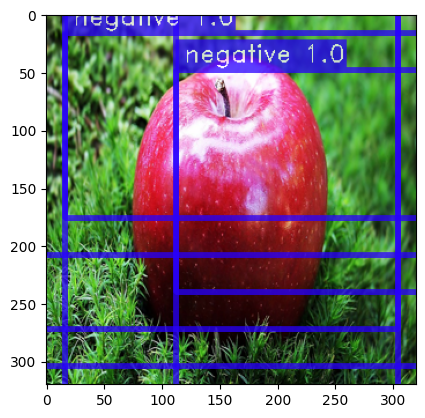

In [383]:
# plt.imshow(np.asarray(predicoes.image,dtype='uint8'))
plt.imshow(np.asarray(predicoes.draw(),dtype='uint8'))
plt.show()